In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats.distributions import norm
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Detecting Data Exfiltration using Producer-consumer ratio and KDE

---

### Problem Statement

Data Exfiltration can be devastating to any Organisation. Moreover, it is challenging to detect for a multitude of reasons spanning across techniques such as overt and covert channels, and the consolidation of data and extraction to physical media.Traditional Data Loss Prevention controls can often fall short, whilst continuous monitoring can suffer from too much noise.

### Experiment

On the premise that networks are built on producer and consumer relationships, it seems intuitive that such relationsips be tracked, baselined and controlled (Carter, Gerth, 2013). This is particularly effective when it comes to evaluating novel data flows. Building upon previous work conducted by Carter and Gerth, here I propose leveraging the Producer-consumer Ratio (PCR) using Kernel Density Estimation (KDE) to establish a probability distribution per Host. The resulting distribution can then used to evaluate the probability of unseen and new flows to determine cases of potential data exfiltration.

\begin{equation}
PCR = (bytesSent - bytesReceived) / (bytesSent + bytesReceived)
\end{equation}



### Data

For this experiment, the UNSW NB15 will be our focus. "The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours". Tcpdump was used to capture raw traffic, with the features generated using Argus and Bro-IDS (NIDS).


References:

* [PCR - A New Flow Metric (Carter and Gerth, 2013)](https://qosient.com/argus/presentations/Argus.FloCon.2014.PCR.Presentation.pdf)


### Data Ingestion

In [3]:
# Get schema
features_df = pd.read_csv('../data/NUSW-NB15_features.csv', encoding='iso-8859-1', index_col='No.')

features_df.head(20)

,Name,Type,Description
No.,,,
1,srcip,nominal,Source IP address
2,sport,integer,Source port number
3,dstip,nominal,Destination IP address
4,dsport,integer,Destination port number
5,proto,nominal,Transaction protocol
6,state,nominal,Indicates to the state and its dependent proto...
7,dur,Float,Record total duration
8,sbytes,Integer,Source to destination transaction bytes
9,dbytes,Integer,Destination to source transaction bytes


In [117]:
# Ingest tcp data
df = pd.read_csv('../data/UNSW-NB15_1.csv', header=None, low_memory=False)

# Assigned column headers using the features dataframe
df.columns = features_df['Name'].T
df.reset_index(drop=True, inplace=True)

df.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [134]:
# Define feature list
features = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'sbytes', 'dbytes', 'attack_cat', 'Label'] 

test_df = df[features]

test_df.head()

Name,srcip,sport,dstip,dsport,proto,sbytes,dbytes,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,132,164,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,528,304,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,146,178,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,132,164,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,146,178,NaN,0


In [140]:
# Choose Host
host_test_df = test_df[(test_df['srcip'] == '175.45.176.0') & (test_df['proto'] == 'tcp') & (test_df['attack_cat'] == 'Reconnaissance')].copy()

host_test_df.head()

Name,srcip,sport,dstip,dsport,proto,sbytes,dbytes,attack_cat,Label
22,175.45.176.0,13284,149.171.126.16,80,tcp,1362,268,Reconnaissance,1
144,175.45.176.0,27804,149.171.126.16,111,tcp,564,354,Reconnaissance,1
2056,175.45.176.0,45372,149.171.126.16,111,tcp,564,354,Reconnaissance,1
3768,175.45.176.0,44308,149.171.126.10,111,tcp,564,354,Reconnaissance,1
4242,175.45.176.0,26184,149.171.126.14,111,tcp,564,354,Reconnaissance,1


### Data Ingestion

In [141]:
# Define PCR equation
def pcr_func(x):
    try:
        return (x['sbytes'] - x['dbytes'])/(x['sbytes'] + x['dbytes'])
    except ZeroDivisionError:
        return 0

# Calculate PCR
host_test_df['pcr'] = host_test_df.apply(pcr_func, axis=1)

host_test_df.head()

Name,srcip,sport,dstip,dsport,proto,sbytes,dbytes,attack_cat,Label,pcr
22,175.45.176.0,13284,149.171.126.16,80,tcp,1362,268,Reconnaissance,1,0.671166
144,175.45.176.0,27804,149.171.126.16,111,tcp,564,354,Reconnaissance,1,0.228758
2056,175.45.176.0,45372,149.171.126.16,111,tcp,564,354,Reconnaissance,1,0.228758
3768,175.45.176.0,44308,149.171.126.10,111,tcp,564,354,Reconnaissance,1,0.228758
4242,175.45.176.0,26184,149.171.126.14,111,tcp,564,354,Reconnaissance,1,0.228758


### Modelling

The bw parameter acts as a smoothing parameter, controlling the tradeoff between bias and variance in the resulting density curve.

In [145]:
# Use Grid Search cross-validation to optimize the bandwidth
bandwidths = 10 ** np.linspace(-1, 1, 100)

# Use Grid Search to Find the Optimal Bandwidth
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=5, iid=False)
grid.fit(host_test_df[['pcr']].iloc[0:1000].values) # first five rows of dataframe)

print("Best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde = grid.best_estimator_

# Score samples
host_test_df['kde'] = np.exp(kde.score_samples(host_test_df[['pcr']]))

host_test_df.head()

Best bandwidth: 0.1


Name,srcip,sport,dstip,dsport,proto,sbytes,dbytes,attack_cat,Label,pcr,kde
22,175.45.176.0,13284,149.171.126.16,80,tcp,1362,268,Reconnaissance,1,0.671166,0.260247
144,175.45.176.0,27804,149.171.126.16,111,tcp,564,354,Reconnaissance,1,0.228758,3.016827
2056,175.45.176.0,45372,149.171.126.16,111,tcp,564,354,Reconnaissance,1,0.228758,3.016827
3768,175.45.176.0,44308,149.171.126.10,111,tcp,564,354,Reconnaissance,1,0.228758,3.016827
4242,175.45.176.0,26184,149.171.126.14,111,tcp,564,354,Reconnaissance,1,0.228758,3.016827


(-1, 1)

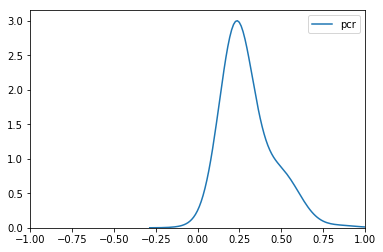

In [146]:
# Plot distribution
sns.kdeplot(host_test_df['pcr'], bw=0.1)
plt.xlim(-1, 1)

### More to come :)